In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                      | 0/60000 [00:00<?, ?it/s]

 12%|██████████████▋                                                                                                         | 7345/60000 [00:00<00:00, 73447.97it/s]

 25%|█████████████████████████████▎                                                                                         | 14779/60000 [00:00<00:00, 73971.17it/s]

 37%|████████████████████████████████████████████                                                                           | 22205/60000 [00:00<00:00, 74098.41it/s]

 49%|██████████████████████████████████████████████████████████▊                                                            | 29622/60000 [00:00<00:00, 74123.21it/s]

 62%|█████████████████████████████████████████████████████████████████████████▍                                             | 37035/60000 [00:00<00:00, 70835.69it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████                               | 44379/60000 [00:00<00:00, 71692.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 51802/60000 [00:00<00:00, 72502.69it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 59067/60000 [00:00<00:00, 69619.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 71393.20it/s]

  0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 6997/10000 [00:00<00:00, 69958.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 70707.60it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 umry49p9


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                        | 0/192 [00:00<?, ?it/s]

  1%|▋                                                                                                                               | 1/192 [00:00<01:56,  1.63it/s]

  2%|██                                                                                                                              | 3/192 [00:00<00:37,  5.05it/s]

  3%|███▎                                                                                                                            | 5/192 [00:00<00:23,  8.11it/s]

  4%|████▋                                                                                                                           | 7/192 [00:00<00:17, 10.70it/s]

  5%|██████                                                                                                                          | 9/192 [00:01<00:14, 12.80it/s]

  6%|███████▎                                                                                                                       | 11/192 [00:01<00:12, 14.41it/s]

  7%|████████▌                                                                                                                      | 13/192 [00:01<00:11, 15.62it/s]

  8%|█████████▉                                                                                                                     | 15/192 [00:01<00:10, 16.53it/s]

  9%|███████████▏                                                                                                                   | 17/192 [00:01<00:10, 17.18it/s]

 10%|████████████▌                                                                                                                  | 19/192 [00:01<00:09, 17.65it/s]

 11%|█████████████▉                                                                                                                 | 21/192 [00:01<00:09, 17.98it/s]

 12%|███████████████▏                                                                                                               | 23/192 [00:01<00:09, 18.22it/s]

 13%|████████████████▌                                                                                                              | 25/192 [00:01<00:09, 18.39it/s]

 14%|█████████████████▊                                                                                                             | 27/192 [00:01<00:08, 18.51it/s]

 15%|███████████████████▏                                                                                                           | 29/192 [00:02<00:08, 18.59it/s]

 16%|████████████████████▌                                                                                                          | 31/192 [00:02<00:08, 18.66it/s]

 17%|█████████████████████▊                                                                                                         | 33/192 [00:02<00:08, 18.70it/s]

 18%|███████████████████████▏                                                                                                       | 35/192 [00:02<00:08, 18.72it/s]

 19%|████████████████████████▍                                                                                                      | 37/192 [00:02<00:08, 18.73it/s]

 20%|█████████████████████████▊                                                                                                     | 39/192 [00:02<00:08, 18.75it/s]

 21%|███████████████████████████                                                                                                    | 41/192 [00:02<00:08, 18.76it/s]

 22%|████████████████████████████▍                                                                                                  | 43/192 [00:02<00:07, 18.76it/s]

 23%|█████████████████████████████▊                                                                                                 | 45/192 [00:02<00:07, 18.77it/s]

 24%|███████████████████████████████                                                                                                | 47/192 [00:03<00:07, 18.77it/s]

 26%|████████████████████████████████▍                                                                                              | 49/192 [00:03<00:07, 18.76it/s]

 27%|█████████████████████████████████▋                                                                                             | 51/192 [00:03<00:07, 18.77it/s]

 28%|███████████████████████████████████                                                                                            | 53/192 [00:03<00:07, 18.73it/s]

 29%|████████████████████████████████████▍                                                                                          | 55/192 [00:03<00:07, 18.73it/s]

 30%|█████████████████████████████████████▋                                                                                         | 57/192 [00:03<00:07, 18.75it/s]

 31%|███████████████████████████████████████                                                                                        | 59/192 [00:03<00:07, 18.76it/s]

 32%|████████████████████████████████████████▎                                                                                      | 61/192 [00:03<00:06, 18.77it/s]

 33%|█████████████████████████████████████████▋                                                                                     | 63/192 [00:03<00:06, 18.77it/s]

 34%|██████████████████████████████████████████▉                                                                                    | 65/192 [00:04<00:06, 18.77it/s]

 35%|████████████████████████████████████████████▎                                                                                  | 67/192 [00:04<00:06, 18.77it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 69/192 [00:04<00:06, 18.78it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 71/192 [00:04<00:06, 18.78it/s]

 38%|████████████████████████████████████████████████▎                                                                              | 73/192 [00:04<00:06, 18.78it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 75/192 [00:04<00:06, 18.77it/s]

 40%|██████████████████████████████████████████████████▉                                                                            | 77/192 [00:04<00:06, 18.77it/s]

 41%|████████████████████████████████████████████████████▎                                                                          | 79/192 [00:04<00:06, 18.77it/s]

 42%|█████████████████████████████████████████████████████▌                                                                         | 81/192 [00:04<00:05, 18.77it/s]

 43%|██████████████████████████████████████████████████████▉                                                                        | 83/192 [00:04<00:05, 18.77it/s]

 44%|████████████████████████████████████████████████████████▏                                                                      | 85/192 [00:05<00:05, 18.79it/s]

 45%|█████████████████████████████████████████████████████████▌                                                                     | 87/192 [00:05<00:05, 18.78it/s]

 46%|██████████████████████████████████████████████████████████▊                                                                    | 89/192 [00:05<00:05, 18.79it/s]

 47%|████████████████████████████████████████████████████████████▏                                                                  | 91/192 [00:05<00:05, 18.79it/s]

 48%|█████████████████████████████████████████████████████████████▌                                                                 | 93/192 [00:05<00:05, 18.80it/s]

 49%|██████████████████████████████████████████████████████████████▊                                                                | 95/192 [00:05<00:05, 18.79it/s]

 51%|████████████████████████████████████████████████████████████████▏                                                              | 97/192 [00:05<00:05, 18.79it/s]

 52%|█████████████████████████████████████████████████████████████████▍                                                             | 99/192 [00:05<00:04, 18.79it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                           | 101/192 [00:05<00:04, 18.79it/s]

 54%|███████████████████████████████████████████████████████████████████▌                                                          | 103/192 [00:06<00:04, 18.80it/s]

 55%|████████████████████████████████████████████████████████████████████▉                                                         | 105/192 [00:06<00:04, 18.80it/s]

 56%|██████████████████████████████████████████████████████████████████████▏                                                       | 107/192 [00:06<00:04, 18.80it/s]

 57%|███████████████████████████████████████████████████████████████████████▌                                                      | 109/192 [00:06<00:04, 18.80it/s]

 58%|████████████████████████████████████████████████████████████████████████▊                                                     | 111/192 [00:06<00:04, 18.79it/s]

 59%|██████████████████████████████████████████████████████████████████████████▏                                                   | 113/192 [00:06<00:04, 18.79it/s]

 60%|███████████████████████████████████████████████████████████████████████████▍                                                  | 115/192 [00:06<00:04, 18.80it/s]

 61%|████████████████████████████████████████████████████████████████████████████▊                                                 | 117/192 [00:06<00:03, 18.80it/s]

 62%|██████████████████████████████████████████████████████████████████████████████                                                | 119/192 [00:06<00:03, 18.80it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▍                                              | 121/192 [00:06<00:03, 18.77it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▋                                             | 123/192 [00:07<00:03, 18.78it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████                                            | 125/192 [00:07<00:03, 18.79it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 127/192 [00:07<00:03, 18.79it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▋                                         | 129/192 [00:07<00:03, 18.79it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 131/192 [00:07<00:03, 18.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▎                                      | 133/192 [00:07<00:03, 18.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                     | 135/192 [00:07<00:03, 18.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                    | 137/192 [00:07<00:02, 18.78it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                  | 139/192 [00:07<00:02, 18.80it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 141/192 [00:08<00:02, 18.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                | 143/192 [00:08<00:02, 18.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 145/192 [00:08<00:02, 18.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 147/192 [00:08<00:02, 18.81it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 149/192 [00:08<00:02, 18.77it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                           | 151/192 [00:08<00:02, 18.76it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 153/192 [00:08<00:02, 18.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 155/192 [00:08<00:01, 18.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                       | 157/192 [00:08<00:01, 18.79it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 159/192 [00:09<00:01, 18.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 161/192 [00:09<00:01, 18.80it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 163/192 [00:09<00:01, 18.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 165/192 [00:09<00:01, 18.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 167/192 [00:09<00:01, 18.79it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 169/192 [00:09<00:01, 18.79it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 171/192 [00:09<00:01, 18.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 173/192 [00:09<00:01, 18.79it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 175/192 [00:09<00:00, 18.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 177/192 [00:09<00:00, 18.80it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 179/192 [00:10<00:00, 18.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 181/192 [00:10<00:00, 18.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 183/192 [00:10<00:00, 18.79it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 185/192 [00:10<00:00, 18.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 187/192 [00:10<00:00, 18.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 189/192 [00:10<00:00, 18.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 191/192 [00:10<00:00, 18.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:10<00:00, 17.80it/s]

train - OK


  0%|                                                                                                                                         | 0/48 [00:00<?, ?it/s]

  2%|██▋                                                                                                                              | 1/48 [00:00<00:05,  8.65it/s]

  6%|████████                                                                                                                         | 3/48 [00:00<00:03, 14.31it/s]

 10%|█████████████▍                                                                                                                   | 5/48 [00:00<00:02, 16.26it/s]

 15%|██████████████████▊                                                                                                              | 7/48 [00:00<00:02, 17.20it/s]

 19%|████████████████████████▏                                                                                                        | 9/48 [00:00<00:02, 17.72it/s]

 23%|█████████████████████████████▎                                                                                                  | 11/48 [00:00<00:02, 17.94it/s]

 27%|██████████████████████████████████▋                                                                                             | 13/48 [00:00<00:01, 18.17it/s]

 31%|████████████████████████████████████████                                                                                        | 15/48 [00:00<00:01, 18.33it/s]

 35%|█████████████████████████████████████████████▎                                                                                  | 17/48 [00:00<00:01, 18.45it/s]

 40%|██████████████████████████████████████████████████▋                                                                             | 19/48 [00:01<00:01, 18.53it/s]

 44%|████████████████████████████████████████████████████████                                                                        | 21/48 [00:01<00:01, 18.59it/s]

 48%|█████████████████████████████████████████████████████████████▎                                                                  | 23/48 [00:01<00:01, 18.61it/s]

 52%|██████████████████████████████████████████████████████████████████▋                                                             | 25/48 [00:01<00:01, 18.64it/s]

 56%|████████████████████████████████████████████████████████████████████████                                                        | 27/48 [00:01<00:01, 18.65it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                  | 29/48 [00:01<00:01, 18.67it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 31/48 [00:01<00:00, 18.68it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 33/48 [00:01<00:00, 18.69it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 35/48 [00:01<00:00, 18.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 37/48 [00:02<00:00, 18.70it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 39/48 [00:02<00:00, 18.67it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 41/48 [00:02<00:00, 18.69it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 43/48 [00:02<00:00, 18.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 45/48 [00:02<00:00, 18.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 47/48 [00:02<00:00, 18.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.97it/s]

val - OK


  0%|                                                                                                                                         | 0/41 [00:00<?, ?it/s]

  2%|███▏                                                                                                                             | 1/41 [00:00<00:04,  8.63it/s]

  7%|█████████▍                                                                                                                       | 3/41 [00:00<00:02, 14.27it/s]

 12%|███████████████▋                                                                                                                 | 5/41 [00:00<00:02, 16.21it/s]

 17%|██████████████████████                                                                                                           | 7/41 [00:00<00:01, 17.16it/s]

 22%|████████████████████████████▎                                                                                                    | 9/41 [00:00<00:01, 17.67it/s]

 27%|██████████████████████████████████▎                                                                                             | 11/41 [00:00<00:01, 18.00it/s]

 32%|████████████████████████████████████████▌                                                                                       | 13/41 [00:00<00:01, 18.21it/s]

 37%|██████████████████████████████████████████████▊                                                                                 | 15/41 [00:00<00:01, 18.35it/s]

 41%|█████████████████████████████████████████████████████                                                                           | 17/41 [00:00<00:01, 18.43it/s]

 46%|███████████████████████████████████████████████████████████▎                                                                    | 19/41 [00:01<00:01, 18.50it/s]

 51%|█████████████████████████████████████████████████████████████████▌                                                              | 21/41 [00:01<00:01, 18.54it/s]

 56%|███████████████████████████████████████████████████████████████████████▊                                                        | 23/41 [00:01<00:00, 18.60it/s]

 61%|██████████████████████████████████████████████████████████████████████████████                                                  | 25/41 [00:01<00:00, 18.63it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 27/41 [00:01<00:00, 18.65it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 29/41 [00:01<00:00, 18.65it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 31/41 [00:01<00:00, 18.66it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 33/41 [00:01<00:00, 18.71it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 35/41 [00:01<00:00, 18.74it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 37/41 [00:02<00:00, 18.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 39/41 [00:02<00:00, 18.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 18.02it/s]

test InD - OK


  0%|                                                                                                                                        | 0/268 [00:00<?, ?it/s]

  0%|▍                                                                                                                               | 1/268 [00:00<00:32,  8.10it/s]

  1%|█▍                                                                                                                              | 3/268 [00:00<00:19, 13.83it/s]

  2%|██▍                                                                                                                             | 5/268 [00:00<00:16, 15.91it/s]

  3%|███▎                                                                                                                            | 7/268 [00:00<00:15, 16.93it/s]

  3%|████▎                                                                                                                           | 9/268 [00:00<00:14, 17.52it/s]

  4%|█████▏                                                                                                                         | 11/268 [00:00<00:14, 17.88it/s]

  5%|██████▏                                                                                                                        | 13/268 [00:00<00:14, 18.09it/s]

  6%|███████                                                                                                                        | 15/268 [00:00<00:13, 18.25it/s]

  6%|████████                                                                                                                       | 17/268 [00:00<00:13, 18.35it/s]

  7%|█████████                                                                                                                      | 19/268 [00:01<00:13, 18.44it/s]

  8%|█████████▉                                                                                                                     | 21/268 [00:01<00:13, 18.49it/s]

  9%|██████████▉                                                                                                                    | 23/268 [00:01<00:13, 18.52it/s]

  9%|███████████▊                                                                                                                   | 25/268 [00:01<00:13, 18.54it/s]

 10%|████████████▊                                                                                                                  | 27/268 [00:01<00:12, 18.55it/s]

 11%|█████████████▋                                                                                                                 | 29/268 [00:01<00:12, 18.52it/s]

 12%|██████████████▋                                                                                                                | 31/268 [00:01<00:12, 18.54it/s]

 12%|███████████████▋                                                                                                               | 33/268 [00:01<00:12, 18.53it/s]

 13%|████████████████▌                                                                                                              | 35/268 [00:01<00:12, 18.54it/s]

 14%|█████████████████▌                                                                                                             | 37/268 [00:02<00:12, 18.54it/s]

 15%|██████████████████▍                                                                                                            | 39/268 [00:02<00:12, 18.54it/s]

 15%|███████████████████▍                                                                                                           | 41/268 [00:02<00:12, 18.56it/s]

 16%|████████████████████▍                                                                                                          | 43/268 [00:02<00:12, 18.56it/s]

 17%|█████████████████████▎                                                                                                         | 45/268 [00:02<00:12, 18.56it/s]

 18%|██████████████████████▎                                                                                                        | 47/268 [00:02<00:11, 18.56it/s]

 18%|███████████████████████▏                                                                                                       | 49/268 [00:02<00:11, 18.56it/s]

 19%|████████████████████████▏                                                                                                      | 51/268 [00:02<00:11, 18.57it/s]

 20%|█████████████████████████                                                                                                      | 53/268 [00:02<00:11, 18.57it/s]

 21%|██████████████████████████                                                                                                     | 55/268 [00:03<00:11, 18.59it/s]

 21%|███████████████████████████                                                                                                    | 57/268 [00:03<00:11, 18.57it/s]

 22%|███████████████████████████▉                                                                                                   | 59/268 [00:03<00:11, 18.57it/s]

 23%|████████████████████████████▉                                                                                                  | 61/268 [00:03<00:11, 18.56it/s]

 24%|█████████████████████████████▊                                                                                                 | 63/268 [00:03<00:11, 18.57it/s]

 24%|██████████████████████████████▊                                                                                                | 65/268 [00:03<00:10, 18.56it/s]

 25%|███████████████████████████████▊                                                                                               | 67/268 [00:03<00:10, 18.56it/s]

 26%|████████████████████████████████▋                                                                                              | 69/268 [00:03<00:10, 18.57it/s]

 26%|█████████████████████████████████▋                                                                                             | 71/268 [00:03<00:10, 18.56it/s]

 27%|██████████████████████████████████▌                                                                                            | 73/268 [00:04<00:10, 18.56it/s]

 28%|███████████████████████████████████▌                                                                                           | 75/268 [00:04<00:10, 18.57it/s]

 29%|████████████████████████████████████▍                                                                                          | 77/268 [00:04<00:10, 18.58it/s]

 29%|█████████████████████████████████████▍                                                                                         | 79/268 [00:04<00:10, 18.57it/s]

 30%|██████████████████████████████████████▍                                                                                        | 81/268 [00:04<00:10, 18.57it/s]

 31%|███████████████████████████████████████▎                                                                                       | 83/268 [00:04<00:09, 18.57it/s]

 32%|████████████████████████████████████████▎                                                                                      | 85/268 [00:04<00:09, 18.58it/s]

 32%|█████████████████████████████████████████▏                                                                                     | 87/268 [00:04<00:09, 18.58it/s]

 33%|██████████████████████████████████████████▏                                                                                    | 89/268 [00:04<00:09, 18.59it/s]

 34%|███████████████████████████████████████████                                                                                    | 91/268 [00:04<00:09, 18.58it/s]

 35%|████████████████████████████████████████████                                                                                   | 93/268 [00:05<00:09, 18.58it/s]

 35%|█████████████████████████████████████████████                                                                                  | 95/268 [00:05<00:09, 18.54it/s]

 36%|█████████████████████████████████████████████▉                                                                                 | 97/268 [00:05<00:09, 18.55it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 99/268 [00:05<00:09, 18.55it/s]

 38%|███████████████████████████████████████████████▍                                                                              | 101/268 [00:05<00:08, 18.56it/s]

 38%|████████████████████████████████████████████████▍                                                                             | 103/268 [00:05<00:08, 18.56it/s]

 39%|█████████████████████████████████████████████████▎                                                                            | 105/268 [00:05<00:08, 18.57it/s]

 40%|██████████████████████████████████████████████████▎                                                                           | 107/268 [00:05<00:08, 18.56it/s]

 41%|███████████████████████████████████████████████████▏                                                                          | 109/268 [00:05<00:08, 18.58it/s]

 41%|████████████████████████████████████████████████████▏                                                                         | 111/268 [00:06<00:08, 18.58it/s]

 42%|█████████████████████████████████████████████████████▏                                                                        | 113/268 [00:06<00:08, 18.58it/s]

 43%|██████████████████████████████████████████████████████                                                                        | 115/268 [00:06<00:08, 18.56it/s]

 44%|███████████████████████████████████████████████████████                                                                       | 117/268 [00:06<00:08, 18.56it/s]

 44%|███████████████████████████████████████████████████████▉                                                                      | 119/268 [00:06<00:08, 18.56it/s]

 45%|████████████████████████████████████████████████████████▉                                                                     | 121/268 [00:06<00:07, 18.54it/s]

 46%|█████████████████████████████████████████████████████████▊                                                                    | 123/268 [00:06<00:07, 18.55it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                   | 125/268 [00:06<00:07, 18.56it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                  | 127/268 [00:06<00:07, 18.47it/s]

 48%|████████████████████████████████████████████████████████████▋                                                                 | 129/268 [00:07<00:07, 18.49it/s]

 49%|█████████████████████████████████████████████████████████████▌                                                                | 131/268 [00:07<00:07, 18.50it/s]

 50%|██████████████████████████████████████████████████████████████▌                                                               | 133/268 [00:07<00:07, 18.52it/s]

 50%|███████████████████████████████████████████████████████████████▍                                                              | 135/268 [00:07<00:07, 18.54it/s]

 51%|████████████████████████████████████████████████████████████████▍                                                             | 137/268 [00:07<00:07, 18.54it/s]

 52%|█████████████████████████████████████████████████████████████████▎                                                            | 139/268 [00:07<00:07, 18.33it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                           | 141/268 [00:07<00:06, 18.41it/s]

 53%|███████████████████████████████████████████████████████████████████▏                                                          | 143/268 [00:07<00:06, 18.47it/s]

 54%|████████████████████████████████████████████████████████████████████▏                                                         | 145/268 [00:07<00:06, 18.49it/s]

 55%|█████████████████████████████████████████████████████████████████████                                                         | 147/268 [00:07<00:06, 18.51it/s]

 56%|██████████████████████████████████████████████████████████████████████                                                        | 149/268 [00:08<00:06, 18.54it/s]

 56%|██████████████████████████████████████████████████████████████████████▉                                                       | 151/268 [00:08<00:06, 18.56it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                      | 153/268 [00:08<00:06, 18.56it/s]

 58%|████████████████████████████████████████████████████████████████████████▊                                                     | 155/268 [00:08<00:06, 18.55it/s]

 59%|█████████████████████████████████████████████████████████████████████████▊                                                    | 157/268 [00:08<00:05, 18.56it/s]

 59%|██████████████████████████████████████████████████████████████████████████▊                                                   | 159/268 [00:08<00:05, 18.51it/s]

 60%|███████████████████████████████████████████████████████████████████████████▋                                                  | 161/268 [00:08<00:05, 18.51it/s]

 61%|████████████████████████████████████████████████████████████████████████████▋                                                 | 163/268 [00:08<00:05, 18.53it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▌                                                | 165/268 [00:08<00:05, 18.54it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▌                                               | 167/268 [00:09<00:05, 18.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▍                                              | 169/268 [00:09<00:05, 18.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▍                                             | 171/268 [00:09<00:05, 18.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                            | 173/268 [00:09<00:05, 18.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                           | 175/268 [00:09<00:05, 18.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▏                                          | 177/268 [00:09<00:04, 18.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                         | 179/268 [00:09<00:04, 18.55it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████                                         | 181/268 [00:09<00:04, 18.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████                                        | 183/268 [00:09<00:04, 18.56it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▉                                       | 185/268 [00:10<00:04, 18.58it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                      | 187/268 [00:10<00:04, 18.58it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                     | 189/268 [00:10<00:04, 18.57it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                    | 191/268 [00:10<00:04, 18.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 193/268 [00:10<00:04, 18.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                  | 195/268 [00:10<00:03, 18.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 197/268 [00:10<00:03, 18.56it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                | 199/268 [00:10<00:03, 18.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 201/268 [00:10<00:03, 18.57it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 203/268 [00:11<00:03, 18.57it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 205/268 [00:11<00:03, 18.57it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 207/268 [00:11<00:03, 18.58it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 209/268 [00:11<00:03, 18.59it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 211/268 [00:11<00:03, 18.60it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 213/268 [00:11<00:02, 18.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                         | 215/268 [00:11<00:02, 18.60it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████                        | 217/268 [00:11<00:02, 18.58it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 219/268 [00:11<00:02, 18.58it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 221/268 [00:11<00:02, 18.57it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 223/268 [00:12<00:02, 18.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 225/268 [00:12<00:02, 18.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 227/268 [00:12<00:02, 18.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 229/268 [00:12<00:02, 18.58it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 231/268 [00:12<00:01, 18.58it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 233/268 [00:12<00:01, 18.59it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 235/268 [00:12<00:01, 18.58it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 237/268 [00:12<00:01, 18.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 239/268 [00:12<00:01, 18.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 241/268 [00:13<00:01, 18.57it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 243/268 [00:13<00:01, 18.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 245/268 [00:13<00:01, 18.57it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 247/268 [00:13<00:01, 18.57it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 249/268 [00:13<00:01, 18.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 251/268 [00:13<00:00, 18.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 253/268 [00:13<00:00, 18.57it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 255/268 [00:13<00:00, 18.59it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 257/268 [00:13<00:00, 18.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 259/268 [00:14<00:00, 18.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 261/268 [00:14<00:00, 18.61it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 263/268 [00:14<00:00, 18.64it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 265/268 [00:14<00:00, 18.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 267/268 [00:14<00:00, 18.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:14<00:00, 18.42it/s]

test OoD - OK


  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

  3%|███▊                                                                                                                            | 3/100 [00:00<00:04, 21.39it/s]

  6%|███████▋                                                                                                                        | 6/100 [00:00<00:04, 21.45it/s]

  9%|███████████▌                                                                                                                    | 9/100 [00:00<00:04, 21.48it/s]

 12%|███████████████▏                                                                                                               | 12/100 [00:00<00:04, 21.48it/s]

 15%|███████████████████                                                                                                            | 15/100 [00:00<00:03, 21.50it/s]

 18%|██████████████████████▊                                                                                                        | 18/100 [00:00<00:03, 21.51it/s]

 21%|██████████████████████████▋                                                                                                    | 21/100 [00:00<00:03, 21.52it/s]

 24%|██████████████████████████████▍                                                                                                | 24/100 [00:01<00:03, 21.51it/s]

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:01<00:03, 21.51it/s]

 30%|██████████████████████████████████████                                                                                         | 30/100 [00:01<00:03, 21.51it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:01<00:03, 21.52it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [00:01<00:02, 21.51it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [00:01<00:02, 21.52it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [00:01<00:02, 21.52it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [00:02<00:02, 21.53it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:02<00:02, 21.53it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [00:02<00:02, 21.52it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:02<00:02, 21.53it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [00:02<00:01, 21.52it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [00:02<00:01, 21.49it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [00:02<00:01, 21.49it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [00:03<00:01, 21.49it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [00:03<00:01, 21.50it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [00:03<00:01, 21.51it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [00:03<00:01, 21.52it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [00:03<00:01, 21.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [00:03<00:00, 21.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [00:03<00:00, 21.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [00:04<00:00, 21.51it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:04<00:00, 21.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [00:04<00:00, 21.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [00:04<00:00, 21.51it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:04<00:00, 21.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.51it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(24476, 1, 32, 32) (24476, 256) (24476, 768) (24476, 1, 32, 32) (24476,)
(6120, 1, 32, 32) (6120, 256) (6120, 768) (6120, 1, 32, 32) (6120,)
(5139, 1, 32, 32) (5139, 256) (5139, 768) (5139, 1, 32, 32) (5139,)
(34265, 1, 32, 32) (34265, 256) (34265, 768) (34265, 1, 32, 32) (34265,)
(12800, 1, 32, 32) (12800, 256) (12800, 768) (12800, 1, 32, 32)


In [11]:
# create tsne embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5139, 2) (34265, 2)


(5139, 2) (34265, 2)


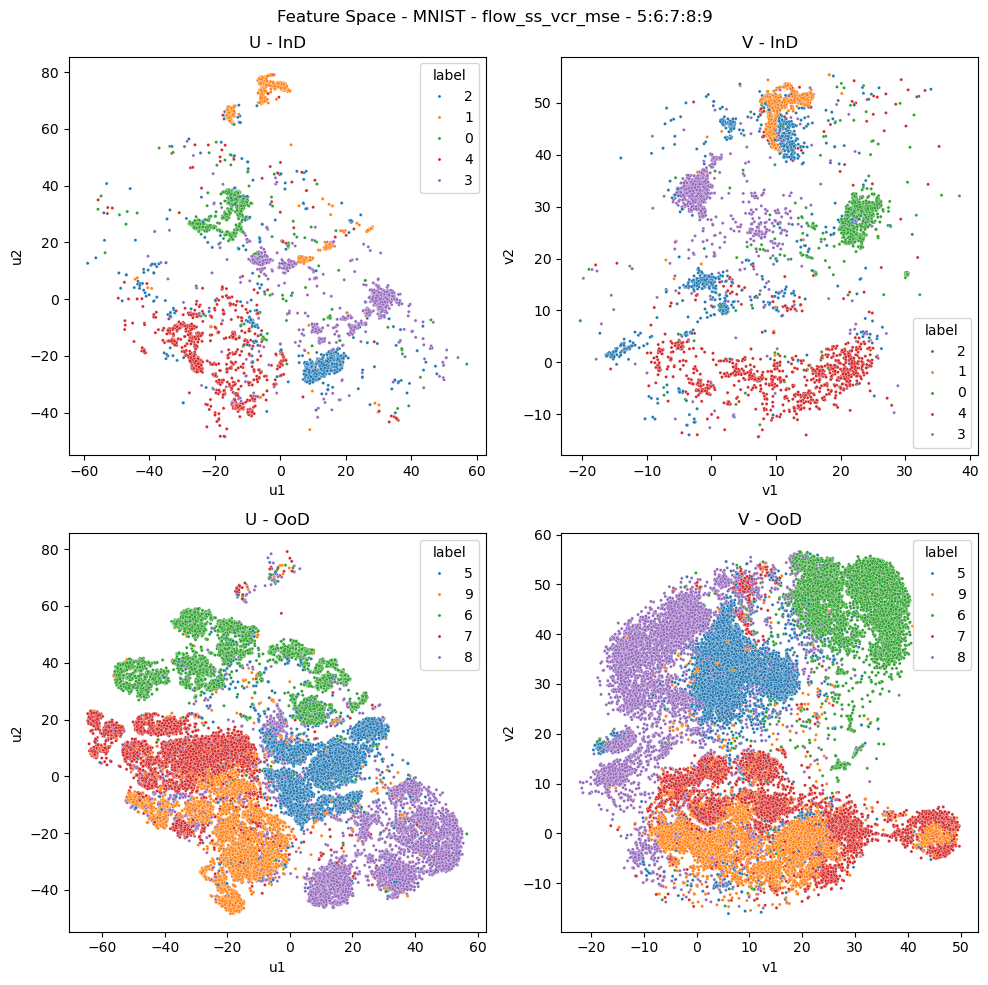

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:01<00:03,  1.07s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:02<00:02,  1.09s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:03<00:01,  1.14s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.19s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:02<00:07,  2.56s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:05<00:05,  2.58s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:07<00:02,  2.63s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.68s/it]

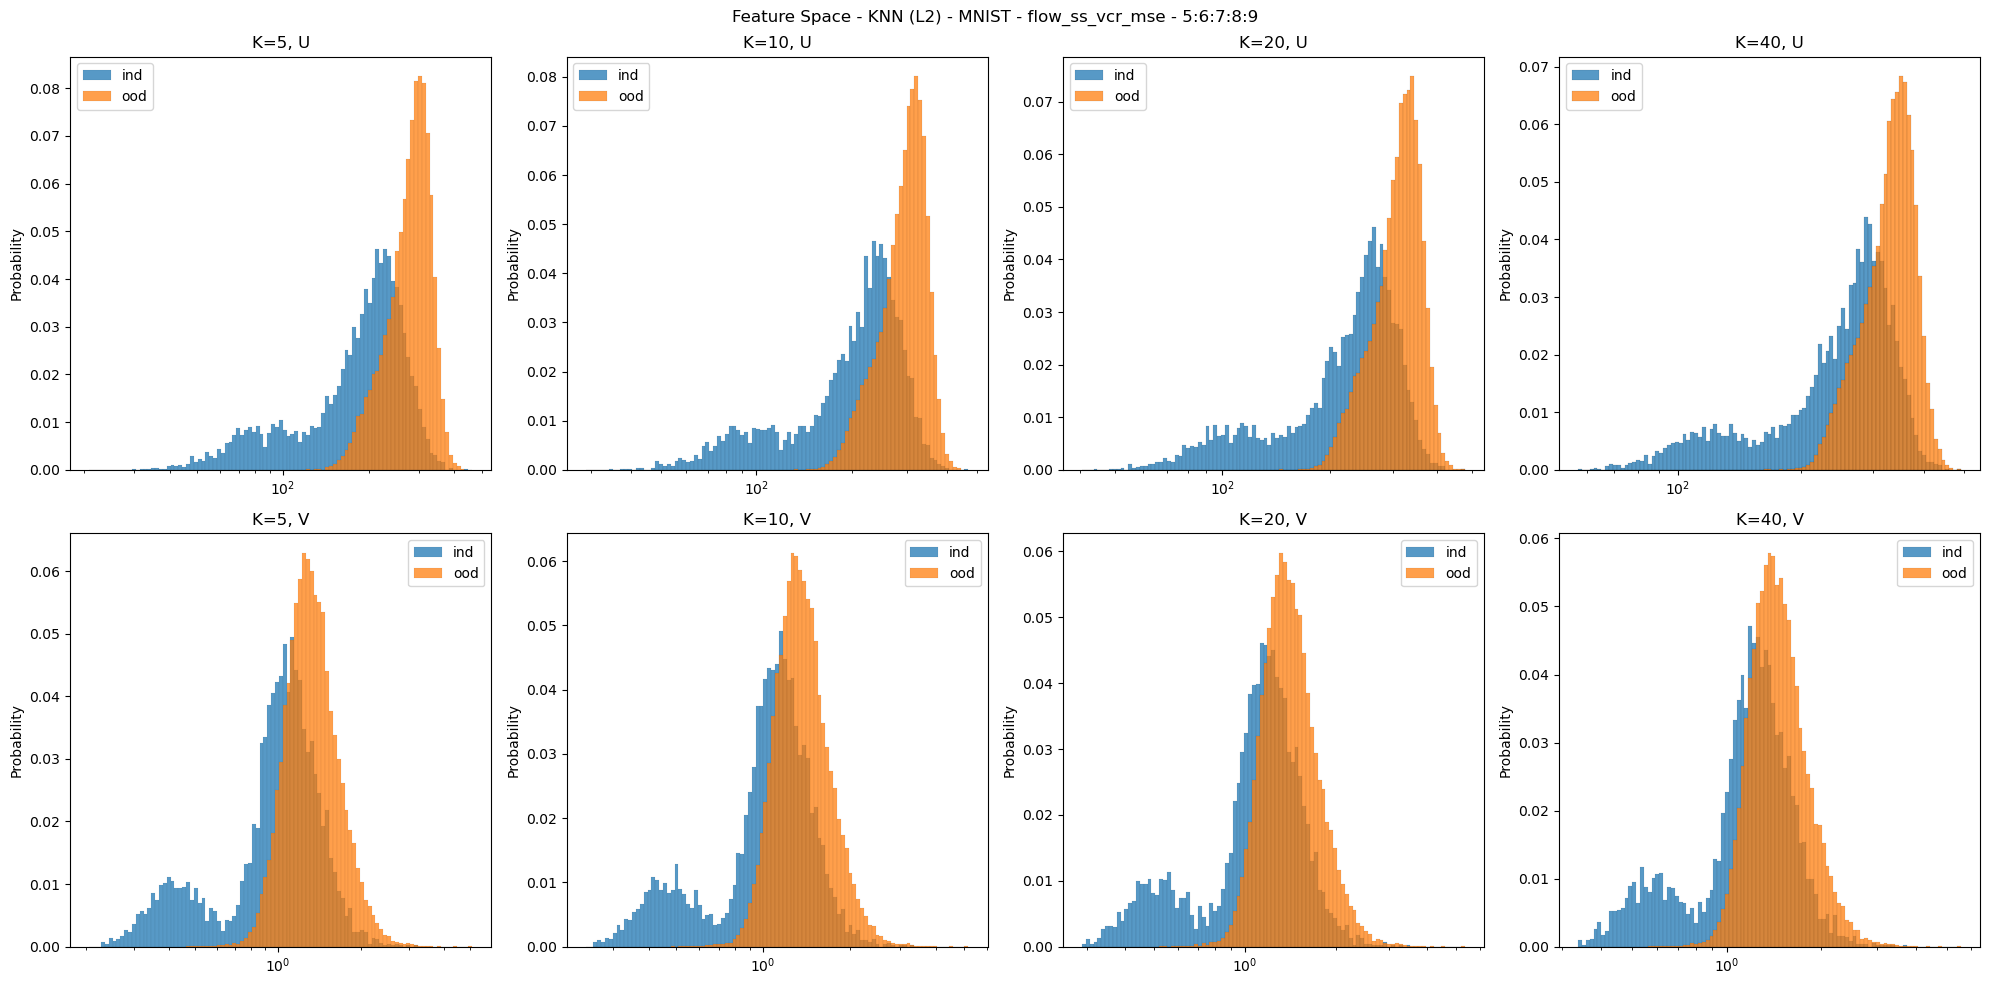

In [13]:
# plot knn to val data in feature space (L2)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:01<00:03,  1.04s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:02<00:02,  1.06s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:03<00:01,  1.11s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.16s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:02<00:07,  2.51s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:05<00:05,  2.54s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:07<00:02,  2.70s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.76s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.70s/it]

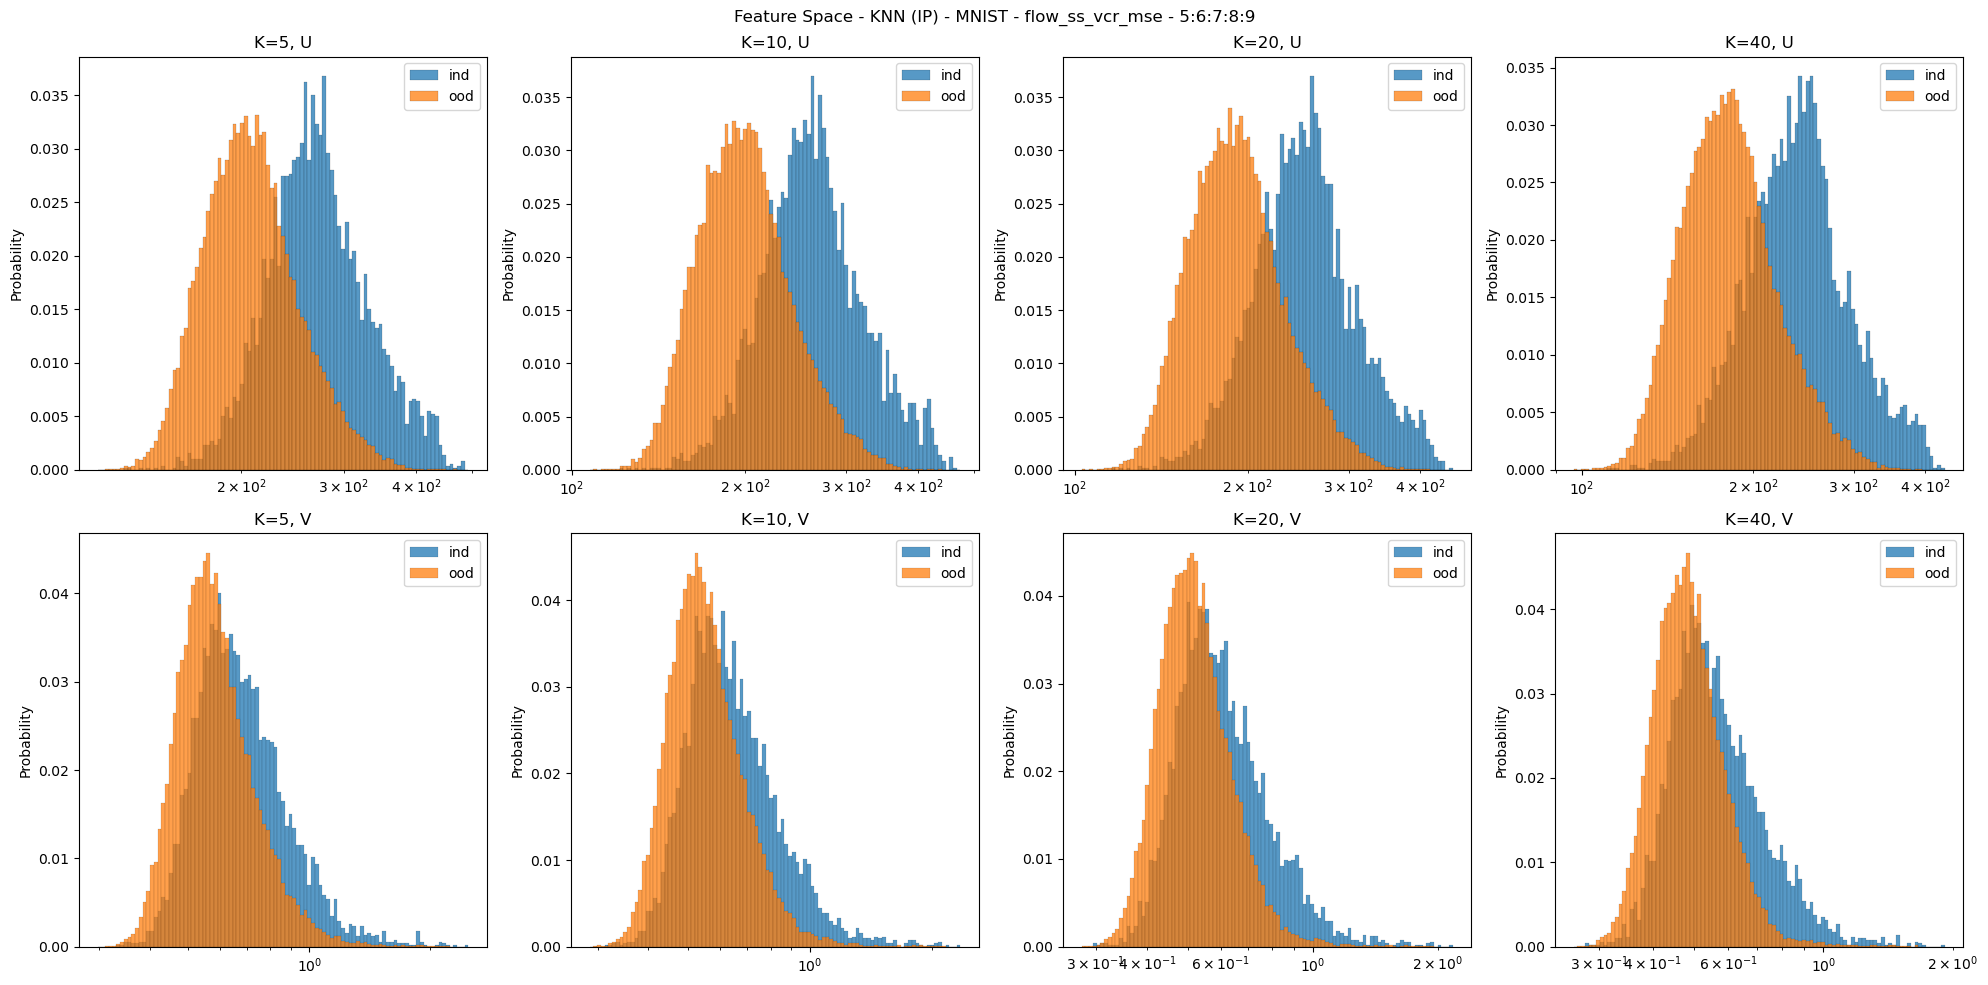

In [14]:
# plot knn to val data in feature space (IP)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

18.974598 1.675561 1.0916508 0.16052052
18.954294 1.644286 1.0940768 0.16482754
19.014482 1.7009993 1.0859902 0.16029623
18.475462 1.3169724 1.147889 0.14863192
33.816624 2.493169 24.853724 0.727023


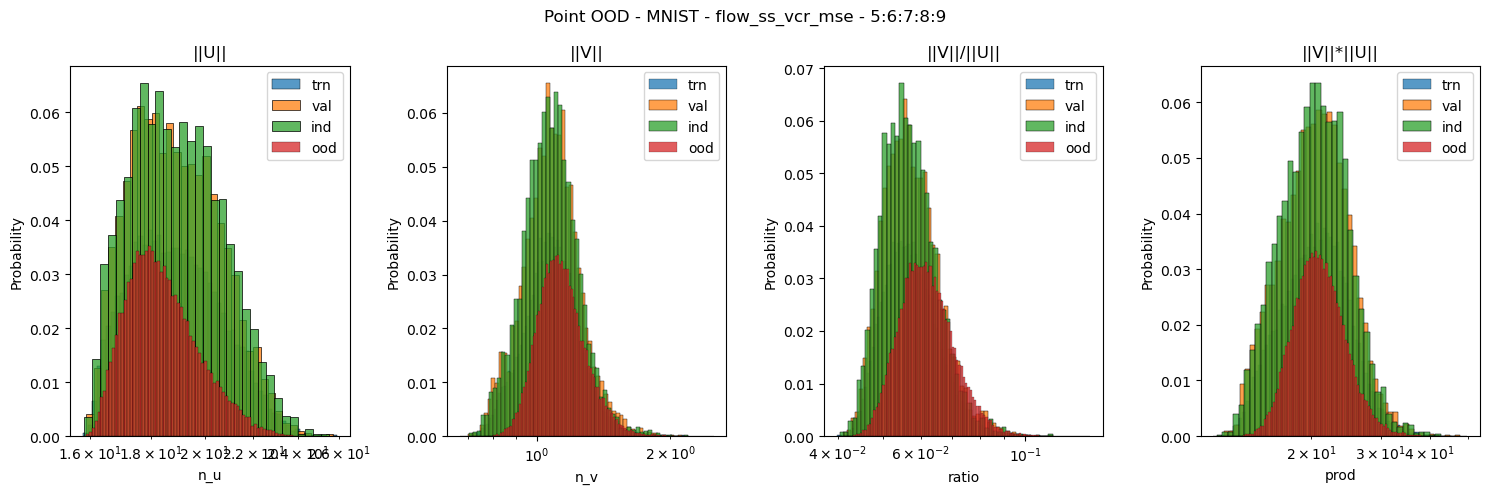

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


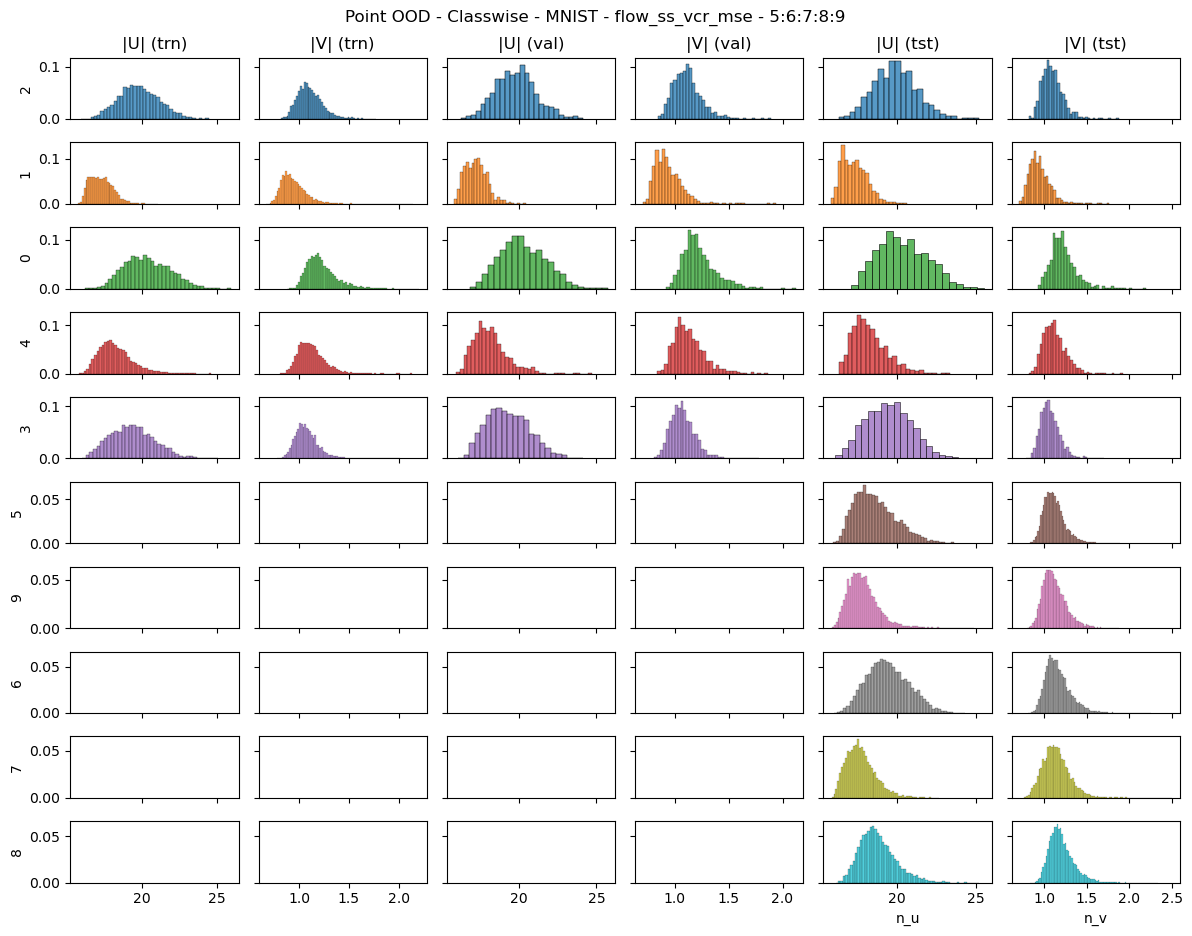

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

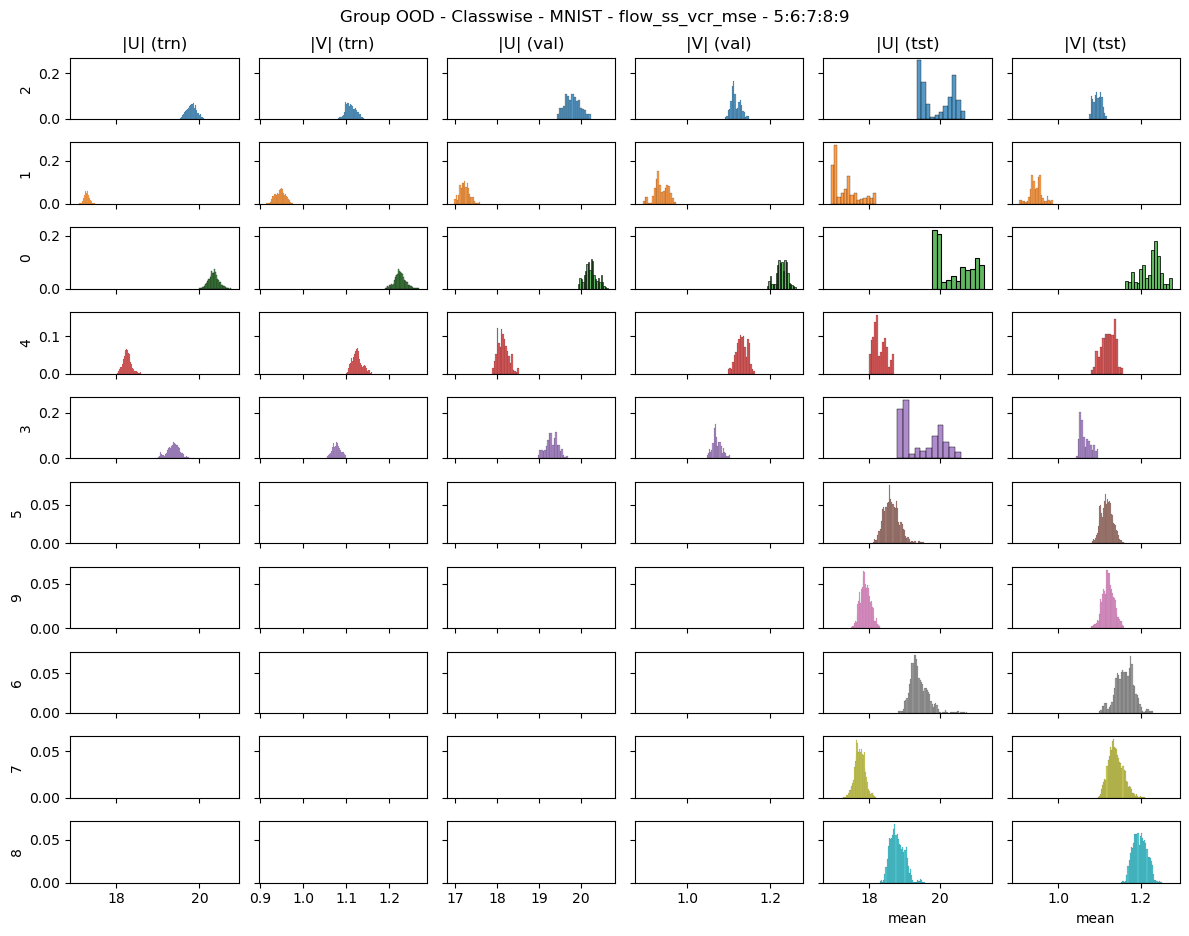

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

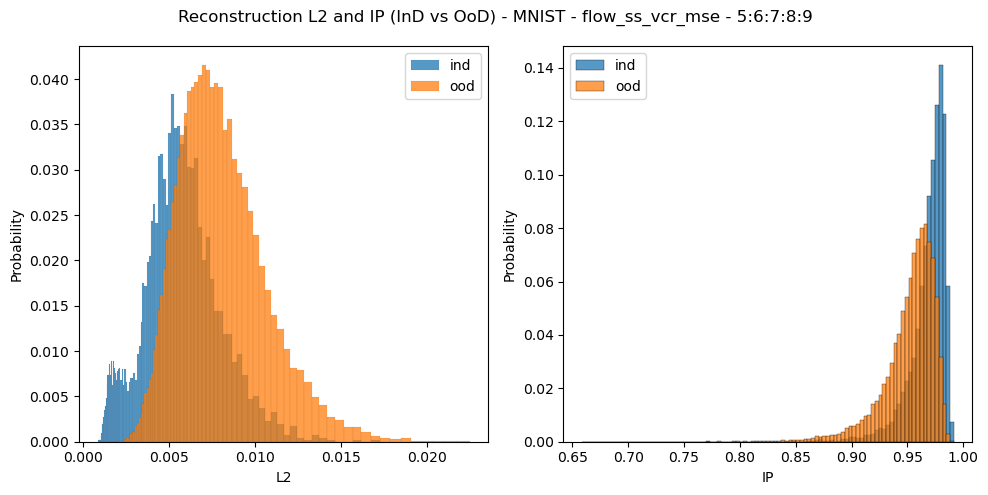

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()